# 【3章】教師無し学習
以下のコードを一部引用しています。
- https://github.com/PacktPublishing/Graph-Machine-Learning/blob/main/Chapter03/01_Shallow_Embeddings.ipynb
- https://github.com/PacktPublishing/Graph-Machine-Learning/blob/main/Chapter03/04_Graph_Neural_Network.ipynb

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import random

from gem.embedding.gf import GraphFactorization
from karateclub import Graph2Vec
import networkx as nx
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
import numpy as np
from scipy.linalg import sqrtm

In [2]:
def draw_graph(G, node_names={}, node_size=500):
    pos_nodes = nx.spring_layout(G)
    nx.draw(G, pos_nodes, with_labels=True, node_size=node_size, edge_color='gray', arrowsize=30)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.show()

## Graph Factorization

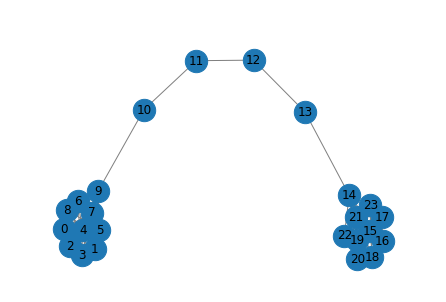

[Errno 2] No such file or directory: 'gem/c_exe/gf': 'gem/c_exe/gf'
./gf not found. Reverting to Python implementation. Please compile gf, place node2vec in the path and grant executable permission
		Iter id: 0, Objective: 95.0025, f1: 94.9992, f2: 0.00333824


(array([[ 0.00376986,  0.00286365],
        [ 0.00376869,  0.00286453],
        [ 0.00377061,  0.00285571],
        [ 0.00377281,  0.0028577 ],
        [ 0.00379374,  0.00294426],
        [ 0.00379367,  0.00281824],
        [ 0.00368229,  0.0027709 ],
        [ 0.00377142,  0.00228422],
        [ 0.00196636,  0.00248264],
        [ 0.00617676,  0.00507129],
        [-0.00068441, -0.00101251],
        [-0.00490735, -0.00417436],
        [-0.00360592, -0.00447939],
        [ 0.00485819, -0.00209684],
        [ 0.01019183, -0.00367254],
        [ 0.01019254, -0.00367313],
        [ 0.01019649, -0.00366993],
        [ 0.01019337, -0.00366241],
        [ 0.0101749 , -0.00366819],
        [ 0.01021885, -0.0037873 ],
        [ 0.01016206, -0.00371558],
        [ 0.01034669, -0.0032709 ],
        [ 0.01109475, -0.00539273],
        [ 0.01045844, -0.0004309 ]]), 7.642887592315674)

In [3]:
G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

gf = GraphFactorization(d=2,  data_set=None,max_iter=10000, eta=1*10**-4, regu=1.0)
gf.learn_embedding(G)

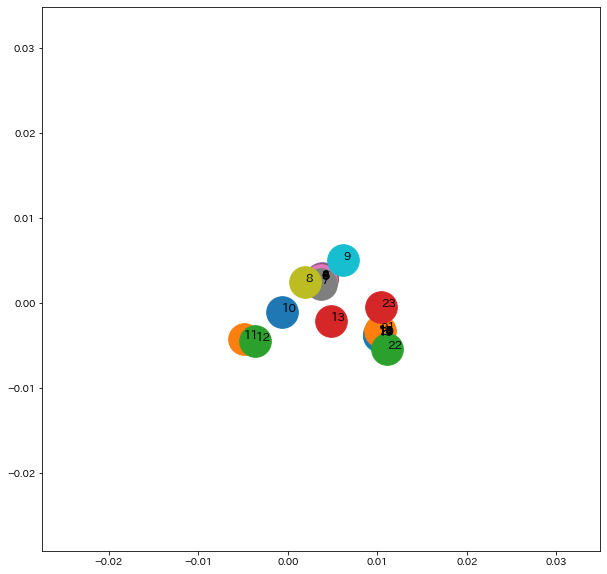

In [4]:
# embeddingした結果を描画
fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():    
    v = gf.get_embedding()[x]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

→グラフ上で密に集まってるノードが、二次元プロット上でもぼんやりとだが集まっているのが分かる

# GCNによるembedding
元論文:[Kipf and Welling 2017](https://arxiv.org/abs/1609.02907)
（GCNの日本語による説明は[こちら](https://y-nakai.com/article/27/)も参考なります。）

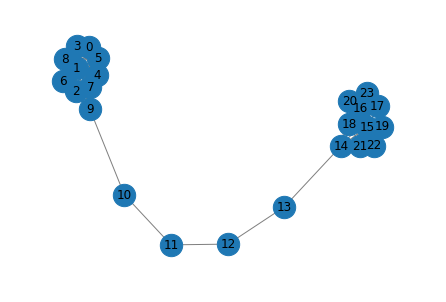

In [5]:
# 畳み込みたいグラフ
G = nx.barbell_graph(m1=10, m2=4)
draw_graph(G)

### GCNの畳み込み計算
畳み込みの計算部分のみフォーカス。

In [6]:
# 隣接行列（グラフコンボリューションに必要な要素）
order = np.arange(G.number_of_nodes())
A = nx.to_numpy_matrix(G, nodelist=order)

# 特徴量行列（各ノードについて特に特徴量が定義されていないので、とりあえず単位行列を特徴量行列とする）
X = np.eye(G.number_of_nodes())

# 隣接行列AにIを足すことで、各ノードに自分自身へのループを追加
I = np.eye(G.number_of_nodes())
A_hat = A + I

# 次数の高い (たくさん接続している) ノードほど一般的に値が大きくなる。一方で、次数の低いノードは特徴量の値が小さくなりがち
# それだと勾配消失や勾配爆発を引き起こす可能性があるので、正規化のような操作が必要
# →次数行列Dの逆行列をかけることで正規化。（ここでの次数行列は各ノードがつながっているノード数+1(自分自身へのループ) を対角行列で表したもの）
order_array_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat_ = np.matrix(np.diag(order_array_hat))
# np.linalg.inv():逆行列を求める, scipy.linalg.sqrtm():平方根を求める
D_hat = np.linalg.inv(sqrtm(D_hat_))  # \hat{D} = \hat{D}^{-1/2}

# @:行列の積を求める(numpy.matmulと同じ)　（行列積実装の説明はこちらが分かりやすい：https://www.headboost.jp/numpy-matmul/)
A_norm = D_hat @ A_hat @ D_hat
# →このA_normとXとフィルターの重みの行列をかける操作が畳み込み（元論文の式(8)）

### GCNの順伝播

In [7]:
# GCNは2層構成
# ここではGlort uniform初期値を使う（一様分布でも正規分布でもいいが)

def glorot_init(nin, nout):
    # Glorot論文: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
    # 数式参考: https://nykergoto.hatenablog.jp/entry/2017/10/15/%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E5%A4%89%E6%95%B0%E3%81%AE%E5%88%9D%E6%9C%9F%E5%8C%96%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6
    np.random.seed(1)  # ここでシード固定しないと、上のセルで固定したとしても変動してしまう
    sd = np.sqrt(6.0 / (nin + nout))
    samples = np.random.uniform(-sd, sd, size=(nin, nout))  # shape: (nout, nin)
    return np.matrix(samples.T)  # shape: (nin, nout)

class GCNLayer():
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = np.tanh
    
    def forward(self, A, X):
        # A: (ノード数, ノード数)
        # X: (ノード数, 特徴量の次元数)
        # W: (入力特徴量の次元数, 出力特徴量の次元数)
        # forward()の出力: (ノード数, 出力特徴量の次元数)
        H = A @ X @ self.W  # (ノード数, 出力特徴量の次元数)
        Z = self.activation(H)
        return Z

In [8]:
gcn1 = GCNLayer(G.number_of_nodes(), 8)
gcn2 = GCNLayer(8, 4)
gcn3 = GCNLayer(4, 2)
H1 = gcn1.forward(A_norm, X)
H2 = gcn2.forward(A_norm, H1)
H3 = gcn3.forward(A_norm, H2)
embeddings = H3

In [9]:
# 元々の特徴量
X

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 

In [10]:
# 畳み込み（隣接ノードの特徴量の加味）と非線形変換を繰り返した結果
embeddings

matrix([[-0.05392365, -0.2342012 ],
        [-0.05392365, -0.2342012 ],
        [-0.05392365, -0.2342012 ],
        [-0.05392365, -0.2342012 ],
        [-0.05392365, -0.2342012 ],
        [-0.05392365, -0.2342012 ],
        [-0.05392365, -0.2342012 ],
        [-0.05392365, -0.2342012 ],
        [-0.05392365, -0.2342012 ],
        [-0.06311942, -0.248162  ],
        [-0.07683135, -0.11562607],
        [-0.12070806, -0.09624975],
        [-0.1256298 , -0.0317024 ],
        [-0.07368378,  0.00311391],
        [ 0.03999775,  0.06282665],
        [ 0.05696026,  0.05759841],
        [ 0.05696026,  0.05759841],
        [ 0.05696026,  0.05759841],
        [ 0.05696026,  0.05759841],
        [ 0.05696026,  0.05759841],
        [ 0.05696026,  0.05759841],
        [ 0.05696026,  0.05759841],
        [ 0.05696026,  0.05759841],
        [ 0.05696026,  0.05759841]])

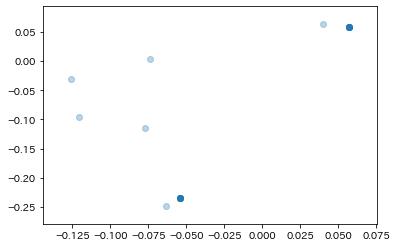

In [11]:
embeddings = np.array(embeddings)
plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.3)

→バーベル型グラフの端のノードがそれぞれ同じようなベクトルに埋め込まれて、分離されているのがわかる（濃い青の点）